---
# **PS S6E2 - Heart Disease Prediction |  XGB + LGBM + CatBoost Ensemble**
---

# *- 1*

In [1]:
import os, gc, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

SEED = 42
N_SPLITS = 5
np.random.seed(SEED)
random.seed(SEED)

print(f"[1/4] Libraries loaded | Seed: {SEED} | Folds: {N_SPLITS}")

[1/4] Libraries loaded | Seed: 42 | Folds: 5


# *- 2*

[2/4] Data loaded | Train: (630000, 15) | Test: (270000, 14) | Original: (270, 14)
    Features: 13 base + 26 external + 10 derived = 49 total


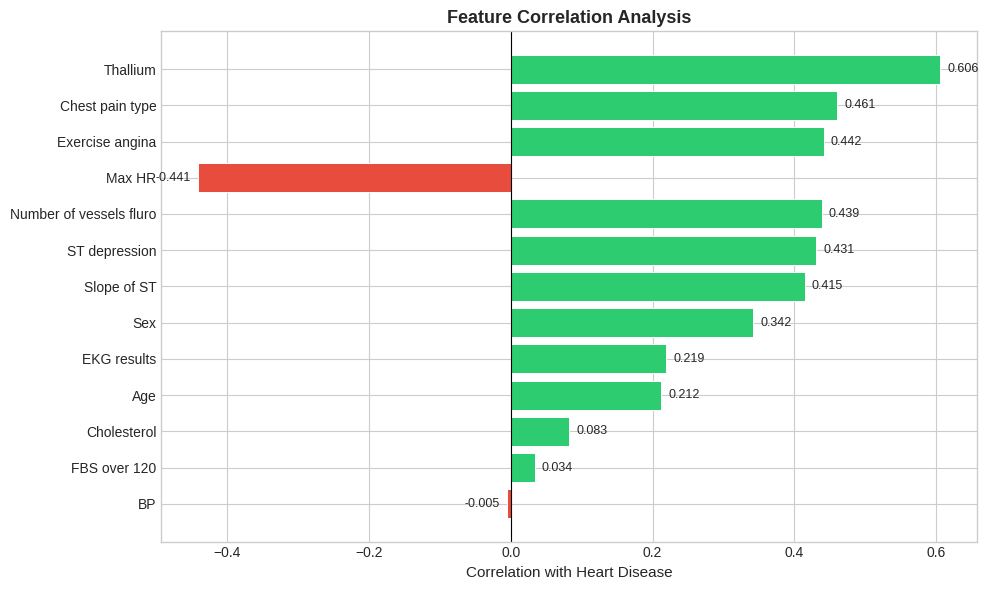

45

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
original = pd.read_csv('/kaggle/input/heartdisease/Heart_Disease_Prediction.csv')

TARGET = 'Heart Disease'
ID_COL = 'id'
BASE = [c for c in train.columns if c not in [ID_COL, TARGET]]

train[TARGET] = train[TARGET].map({'Absence': 0, 'Presence': 1})
original[TARGET] = original[TARGET].map({'Absence': 0, 'Presence': 1})

print(f"[2/4] Data loaded | Train: {train.shape} | Test: {test.shape} | Original: {original.shape}")
ORIG_FEATS = []
global_mean = original[TARGET].mean()

for col in BASE:
    if col not in original.columns:
        continue
    mean_map = original.groupby(col)[TARGET].mean()
    count_map = original[col].value_counts().to_dict()
    
    train[f'orig_mean_{col}'] = train[col].map(mean_map).fillna(global_mean)
    test[f'orig_mean_{col}'] = test[col].map(mean_map).fillna(global_mean)
    train[f'orig_count_{col}'] = train[col].map(count_map).fillna(0)
    test[f'orig_count_{col}'] = test[col].map(count_map).fillna(0)
    ORIG_FEATS.extend([f'orig_mean_{col}', f'orig_count_{col}'])

for df in [train, test]:
    df['age_cholesterol'] = df['Age'] * df['Cholesterol']
    df['bp_age'] = df['BP'] * df['Age']
    df['vessels_thallium'] = df['Number of vessels fluro'] * df['Thallium']
    df['chest_pain_vessels'] = df['Chest pain type'] * df['Number of vessels fluro']
    df['hr_age_ratio'] = df['Max HR'] / (df['Age'] + 1)
    df['cholesterol_age_ratio'] = df['Cholesterol'] / (df['Age'] + 1)
    df['bp_ratio'] = df['BP'] / (df['Age'] + 1)
    df['heart_risk_score'] = df['Thallium'] * 3 + df['Chest pain type'] * 2 + df['Number of vessels fluro'] * 2
    df['thallium_sq'] = df['Thallium'] ** 2
    df['chest_pain_sq'] = df['Chest pain type'] ** 2

DERIVED = ['age_cholesterol', 'bp_age', 'vessels_thallium', 'chest_pain_vessels', 
           'hr_age_ratio', 'cholesterol_age_ratio', 'bp_ratio', 'heart_risk_score',
           'thallium_sq', 'chest_pain_sq']

FEATURES = BASE + ORIG_FEATS + DERIVED

X = train[FEATURES].astype(np.float32)
y = train[TARGET]
X_test = test[FEATURES].astype(np.float32)

print(f"    Features: {len(BASE)} base + {len(ORIG_FEATS)} external + {len(DERIVED)} derived = {len(FEATURES)} total")


corr_df = train[BASE + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(key=abs, ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in corr_df.values]
bars = ax.barh(corr_df.index, corr_df.values, color=colors, edgecolor='white', linewidth=0.7)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Correlation with Heart Disease', fontsize=11)
ax.set_title('Feature Correlation Analysis', fontsize=13, fontweight='bold')
for i, (val, name) in enumerate(zip(corr_df.values, corr_df.index)):
    ax.text(val + 0.01 if val >= 0 else val - 0.01, i, f'{val:.3f}', 
            va='center', ha='left' if val >= 0 else 'right', fontsize=9)
plt.tight_layout()
plt.show()

gc.collect()

# *- 3*

In [3]:

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_xgb = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))

pred_xgb = np.zeros(len(X_test))
pred_lgb = np.zeros(len(X_test))
pred_cat = np.zeros(len(X_test))

ver = tuple(int(x) for x in xgb.__version__.split('.')[:2])

xgb_params = {
    'n_estimators': 5000, 'learning_rate': 0.02, 'max_depth': 6,
    'subsample': 0.85, 'colsample_bytree': 0.85, 'min_child_weight': 3,
    'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 2.0,
    'random_state': SEED, 'n_jobs': -1, 'eval_metric': 'auc',
    'tree_method': 'hist', 'device': 'cuda' if ver >= (2, 0) else 'gpu'
}
if ver < (2, 0):
    xgb_params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'})
    del xgb_params['device']

lgb_params = {
    'n_estimators': 5000, 'learning_rate': 0.02, 'num_leaves': 64,
    'subsample': 0.85, 'colsample_bytree': 0.85, 'reg_lambda': 1.5,
    'random_state': SEED, 'n_jobs': -1, 'device': 'cpu', 'verbose': -1
}
cat_params = {
    'iterations': 5000, 'learning_rate': 0.02, 'depth': 8,
    'l2_leaf_reg': 3.0, 'random_seed': SEED, 'task_type': 'GPU',
    'devices': '0', 'verbose': False, 'eval_metric': 'AUC'
}

print(f"[3/4] Training {N_SPLITS}-Fold CV...\n")

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
    oof_xgb[va_idx] = xgb_model.predict_proba(X_va)[:, 1]
    pred_xgb += xgb_model.predict_proba(X_test)[:, 1] / N_SPLITS
    
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                  callbacks=[lgb.early_stopping(200, verbose=False)])
    oof_lgb[va_idx] = lgb_model.predict_proba(X_va)[:, 1]
    pred_lgb += lgb_model.predict_proba(X_test)[:, 1] / N_SPLITS
    
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_tr, y_tr, eval_set=(X_va, y_va), early_stopping_rounds=200)
    oof_cat[va_idx] = cat_model.predict_proba(X_va)[:, 1]
    pred_cat += cat_model.predict_proba(X_test)[:, 1] / N_SPLITS
    
    xgb_auc = roc_auc_score(y_va, oof_xgb[va_idx])
    lgb_auc = roc_auc_score(y_va, oof_lgb[va_idx])
    cat_auc = roc_auc_score(y_va, oof_cat[va_idx])
    
    print(f"  Fold {fold} | XGB: {xgb_auc:.5f} | LGB: {lgb_auc:.5f} | CAT: {cat_auc:.5f}")
    
    del xgb_model, lgb_model, cat_model
    gc.collect()

auc_xgb = roc_auc_score(y, oof_xgb)
auc_lgb = roc_auc_score(y, oof_lgb)
auc_cat = roc_auc_score(y, oof_cat)

print(f"\n  ┌{'─'*45}┐")
print(f"  │ {'Model':<12} │ {'OOF AUC':^12} │ {'Weight':^12} │")
print(f"  ├{'─'*45}┤")

total_auc = auc_xgb + auc_lgb + auc_cat
w_xgb, w_lgb, w_cat = auc_xgb/total_auc, auc_lgb/total_auc, auc_cat/total_auc

print(f"  │ {'XGBoost':<12} │ {auc_xgb:^12.6f} │ {w_xgb:^12.4f} │")
print(f"  │ {'LightGBM':<12} │ {auc_lgb:^12.6f} │ {w_lgb:^12.4f} │")
print(f"  │ {'CatBoost':<12} │ {auc_cat:^12.6f} │ {w_cat:^12.4f} │")
print(f"  └{'─'*45}┘")

[3/4] Training 5-Fold CV...



Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 1 | XGB: 0.95464 | LGB: 0.95545 | CAT: 0.95566


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 2 | XGB: 0.95353 | LGB: 0.95439 | CAT: 0.95459


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 3 | XGB: 0.95453 | LGB: 0.95521 | CAT: 0.95544


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 4 | XGB: 0.95395 | LGB: 0.95488 | CAT: 0.95506


Default metric period is 5 because AUC is/are not implemented for GPU


  Fold 5 | XGB: 0.95474 | LGB: 0.95564 | CAT: 0.95582

  ┌─────────────────────────────────────────────┐
  │ Model        │   OOF AUC    │    Weight    │
  ├─────────────────────────────────────────────┤
  │ XGBoost      │   0.954275   │    0.3331    │
  │ LightGBM     │   0.955110   │    0.3334    │
  │ CatBoost     │   0.955312   │    0.3335    │
  └─────────────────────────────────────────────┘


# *- 4*

In [4]:
oof_blend = w_xgb * oof_xgb + w_lgb * oof_lgb + w_cat * oof_cat
pred_blend = w_xgb * pred_xgb + w_lgb * pred_lgb + w_cat * pred_cat

auc_blend = roc_auc_score(y, oof_blend)
print(f"[4/4] Ensemble OOF AUC: {auc_blend:.6f}\n")

sub = pd.read_csv('/kaggle/input/playground-series-s6e2/sample_submission.csv')

sub[TARGET] = pred_blend
sub.to_csv('submission.csv', index=False)

sub[TARGET] = pred_xgb
sub.to_csv('submission_xgb.csv', index=False)

sub[TARGET] = pred_lgb
sub.to_csv('submission_lgb.csv', index=False)

sub[TARGET] = pred_cat
sub.to_csv('submission_cat.csv', index=False)

print("  ┌" + "─"*50 + "┐")
print(f"  │ {'File':<28} │ {'OOF AUC':^17} │")
print("  ├" + "─"*50 + "┤")
print(f"  │ {'submission.csv (Ensemble)':<28} │ {auc_blend:^17.6f} │")
print(f"  │ {'submission_xgb.csv':<28} │ {auc_xgb:^17.6f} │")
print(f"  │ {'submission_lgb.csv':<28} │ {auc_lgb:^17.6f} │")
print(f"  │ {'submission_cat.csv':<28} │ {auc_cat:^17.6f} │")
print("  └" + "─"*50 + "┘")
print("\n✓ All submissions saved.")

[4/4] Ensemble OOF AUC: 0.955206

  ┌──────────────────────────────────────────────────┐
  │ File                         │      OOF AUC      │
  ├──────────────────────────────────────────────────┤
  │ submission.csv (Ensemble)    │     0.955206      │
  │ submission_xgb.csv           │     0.954275      │
  │ submission_lgb.csv           │     0.955110      │
  │ submission_cat.csv           │     0.955312      │
  └──────────────────────────────────────────────────┘

✓ All submissions saved.


 # *- the end :)*